In [1]:
import pandas as pd
import numpy as np 
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import metrics
nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package vader_lexicon to C:\Users\Priyanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
Suicide = pd.read_csv('../Priyanshu Singh/Suicide_Detection.csv')
data_split = np.array_split(Suicide, 3)
Suicide = data_split[0]
Suicide = Suicide.drop('Unnamed: 0',axis=1)

*Preparing For Stopword removal and lemmatization*


In [4]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Priyanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X = Suicide.drop('class', axis=1)
y = Suicide['class']

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Priyanshu
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# To remove emails
email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
regexes_to_remove = [email_regex, r'Subject:', r'Re:']

for i in range(0, len(X)):
    # removing all special charachter
    review = re.sub('[^a-zA-Z]', ' ', str(X['text'][i]))
    # make document as lowerCase
    review = review.lower()
    # splitting the documents into words for ex ['iam', 'omar']
    review = review.split()
    # make limmatization --> (change, changing, changes)---> (change)
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
    # join the document agian
    review = ' '.join(review)
    
    # removing mails
    for r in regexes_to_remove:
        X['text'][i] = re.sub(r, '', review)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer_n12 = TfidfVectorizer(max_features=10000, ngram_range=(1,2))


X_tfidf_train = tfidf_vectorizer.fit_transform(X_train['text'])
X_tfidf_test = tfidf_vectorizer.transform(X_test['text'])

X_tfidf_train_n12= tfidf_vectorizer_n12.fit_transform(X_train['text'])
X_tfidf_test_n12=tfidf_vectorizer_n12.transform(X_test['text'])

In [10]:
vectorizer = CountVectorizer()
  
X_bow_train = vectorizer.fit_transform(X_train['text'])
X_bow_test = vectorizer.transform(X_test['text'])

### Vader


In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
def get_vader_scores(data):
    sid=SIA()
    vader_df=data.copy()
    vader_df['scores'] = vader_df['text'].apply(lambda txt: sid.polarity_scores(str(txt)))
    
    vader_df['neg_score'] = vader_df['scores'].apply(lambda txt: txt['neg'])
    vader_df['neu_score'] =vader_df['scores'].apply(lambda txt: txt['neu'])
    vader_df['pos_score'] = vader_df['scores'].apply(lambda txt: txt['pos'])
    vader_df['compound'] = vader_df['scores'].apply(lambda txt: txt['compound'])
    vader_df.drop('scores', axis=1, inplace=True)
    vader_df.drop('text', axis=1, inplace=True)
    return vader_df


In [12]:
X_vader_train = get_vader_scores(X_train)
X_vader_test= get_vader_scores(X_test)

###Feature Selection


In [13]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [14]:
# We Can select any model but linearSVC has l1 norm penality which deals with sparse
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_tfidf_train, y_train)

# This function select the best features that has high weigh
fs = SelectFromModel(lsvc, prefit=True)
# This function redeuce X to the selected features
X_selection = fs.transform(X_tfidf_train)
X_test_selection = fs.transform(X_tfidf_test)


lsvc.fit(X_tfidf_train_n12, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_n12 = fs_n12.transform(X_tfidf_train_n12)
X_test_selection_n12 = fs_n12.transform(X_tfidf_test_n12)

lsvc.fit(X_bow_train, y_train)
fs_n12 = SelectFromModel(lsvc, prefit=True)
X_selection_bow = fs_n12.transform(X_bow_train)
X_test_selection_bow = fs_n12.transform(X_bow_test)

In [15]:
import matplotlib.pyplot as plt
def plot_results(data):
    
    barWidth = 0.15
    # set heights of bars

    bars1 = [data[0][1],data[1][1], data[2][1]]
    bars2 = [data[0][2], data[1][2], data[2][2]]
    bars3 = [data[0][3], data[1][3], data[2][3]]
    bars4 = [data[0][4], data[1][4], data[2][4]]
    

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    

    # Make the plot
    plt.bar(r1, bars1, color='r', width=barWidth, edgecolor='white', label='tfidf')
    plt.bar(r2, bars2, color='b', width=barWidth, edgecolor='white', label='tfidf_n12')
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='bow')
    plt.bar(r4, bars4, color='#9a7f5e', width=barWidth, edgecolor='white', label='vader')
    

    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars1))], ['precision', 'recall', 'f1-score'])

    # Create legend & Show graphic
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_selection, y_train)
y_predict_tfidf = lsvc.predict(X_test_selection)

lsvc.fit(X_selection_n12,y_train)
y_predict_tfidf_n12 = lsvc.predict(X_test_selection_n12)

lsvc.fit(X_selection_bow,y_train)
y_predict_bow = lsvc.predict(X_test_selection_bow)

lsvc.fit(X_vader_train,y_train)
y_predict_vader = lsvc.predict(X_vader_test)

linear_svm_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf)
linear_svm_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12)
linear_svm_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow)
vader_svm_results=metrics.precision_recall_fscore_support(y_test, y_predict_vader)

In [23]:
tfidf_acc= metrics.accuracy_score(y_test, y_predict_tfidf)
tfidf_n12_acc=accuracy_score(y_test, y_predict_tfidf_n12)
bow_acc= accuracy_score(y_test, y_predict_bow)
vader_acc=accuracy_score(y_test, y_predict_vader)

In [18]:
data1 = [['TF-IDF','TF-IDF 2-grams ','bag of words','vader'],
         ['precision',linear_svm_tfidf_results[0][0],linear_svm_tfidf_n12_results[0][0],linear_svm_bow_results[0][0],
          vader_svm_results[0][0]],
         ['recall',linear_svm_tfidf_results[1][0],linear_svm_tfidf_n12_results[1][0],linear_svm_bow_results[1][0],
          vader_svm_results[1][0]],
         ['F1-score',linear_svm_tfidf_results[2][0],linear_svm_tfidf_n12_results[2][0],linear_svm_bow_results[2][0],
          vader_svm_results[2][0]],
        ['accuracy',tfidf_acc,tfidf_n12_acc,bow_acc,
          vader_acc]]

In [19]:
print(tabulate(data1,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════╤══════════╤═══════════════════╤════════════════╤══════════╕
│           │   TF-IDF │   TF-IDF 2-grams  │   bag of words │    vader │
╞═══════════╪══════════╪═══════════════════╪════════════════╪══════════╡
│ precision │ 0.867155 │          0.876351 │       0.86864  │ 0.687182 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ recall    │ 0.857438 │          0.838735 │       0.872608 │ 0.709274 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ F1-score  │ 0.862269 │          0.85713  │       0.87062  │ 0.698053 │
├───────────┼──────────┼───────────────────┼────────────────┼──────────┤
│ accuracy  │ 0.863064 │          0.860221 │       0.870346 │ 0.693252 │
╘═══════════╧══════════╧═══════════════════╧════════════════╧══════════╛


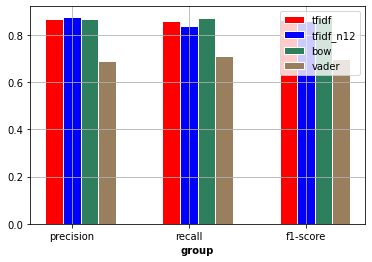

In [20]:
plot_results(data1[1:])

RandomForest_tfidf_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_2)
RandomForest_tfidf_n12_results=metrics.precision_recall_fscore_support(y_test, y_predict_tfidf_n12_2)
RandomForest_bow_results=metrics.precision_recall_fscore_support(y_test, y_predict_bow_2)
RandomForest_vader_results=metrics.precision_recall_fscore_support(y_test, y_predict_vader_2)

Using random Forest